A well known issue with Sentinel-1 frames as they are distributed is that they are not consistent in time. A fixed-size frame can move along track North or South. This makes time-series enumeration of SLCs for interferograms more complciated.

This notebook takes us through  making the Sentinel-1 "fixed-frames" (or here just "frames") derived from the burst footprints. Bursts are fixed footprints that represent imaging area of the Sentinel-1 IW-mode SAR. The burst map data has generated huge excitement because they represent fixed gegraphic areas through time. The frames that we are defining are a self-imposed organization scheme to allow us to perform large regional scale time-series analysis at roughly the scale of the originally distributed ESA frames.

The burst maps are downloaded from ESA [page](https://sar-mpc.eu/test-data-sets/). We downloaded `S1_burstid_20220530`.

There is some discussion about the metadata found in this table the next notebook. Here, we jumping right to do it to take each burst (across all three swaths) and collect them into a group of 10 within a "frame" so that each frame has a 2 burst overlap. Of course, the number of bursts within a frame and of overlapping neighboring frames could easily be re-configured here. These are based on the approximate size of frames as they are currently distributed via ESA.

In [1]:
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from dem_stitcher.datasets import get_dem_tile_extents
from rasterio.crs import CRS
import warnings

In [2]:
LAND_INTERSECTION = 'usgs' 

assert LAND_INTERSECTION in ['world_ne', 'glo_30', 'usgs']

# Read Burst Data

The data needs to be unzipped first in this directory.

In [3]:
%time

# SQL must wrap the geometry in hex(st_asbinary(...))
sql = "SELECT * FROM burst_id_map;"
con = sqlite3.connect("S1_burstid_20220530/IW/sqlite/burst_map_IW_000001_375887.sqlite3")

df_burst = gpd.GeoDataFrame.from_postgis(sql, con, geom_col="GEOMETRY")

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [4]:
df_burst.head()

,OGC_FID,GEOMETRY,burst_id,subswath_name,relative_orbit_number,time_from_anx_sec,orbit_pass
0,1,"MULTIPOLYGON Z (((3.36758 0.75322 0.00000, 3.7...",1,IW1,1,2.301015,ASCENDING
1,2,"MULTIPOLYGON Z (((4.09178 0.97402 0.00000, 4.5...",1,IW2,1,3.133218,ASCENDING
2,3,"MULTIPOLYGON Z (((4.85545 1.19200 0.00000, 5.2...",1,IW3,1,4.211255,ASCENDING
3,4,"MULTIPOLYGON Z (((3.33269 0.92005 0.00000, 3.7...",2,IW1,1,5.059288,ASCENDING
4,5,"MULTIPOLYGON Z (((4.05690 1.14071 0.00000, 4.4...",2,IW2,1,5.891491,ASCENDING


# Burst Aggregation

Each burst covers three swaths. So we want to merge these bursts together as a single geometric object.

<AxesSubplot:>

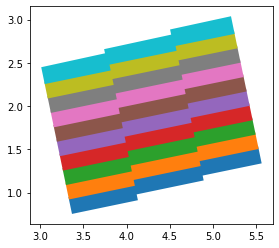

In [5]:
df_burst.head(30).plot(column='burst_id', categorical=True)

In [6]:
%%time

def join_track_numbers(orbits: list) -> str:
    orbits = list(set(orbits))
    orbits_str = list(map(str, orbits))
    return ','.join(orbits_str)


df_burst_triplet_temp = df_burst.dissolve(by='burst_id', 
                                          aggfunc={'OGC_FID': ['min', 'max'],
                                                   'relative_orbit_number': join_track_numbers,
                                                   'orbit_pass': 'first'}, 
                                          as_index=False)

CPU times: user 2min 35s, sys: 884 ms, total: 2min 36s
Wall time: 2min 36s


/Users/cmarshak/opt/anaconda3/envs/s1-enumerator/lib/python3.9/site-packages/pandas/core/frame.py:9130: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  return merge(


We keep store this as an alternative dataframe because we want to rename columns.

In [8]:
df_burst_triplet_temp.head()

,burst_id,GEOMETRY,"(OGC_FID, min)","(OGC_FID, max)","(relative_orbit_number, join_track_numbers)","(orbit_pass, first)"
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


In [9]:
df_burst_triplet = df_burst_triplet_temp.copy()
df_burst_triplet.columns = ['burst_id', 
                            'geometry', 
                            'OGC_FID_min', 
                            'OGC_FID_max', 
                            'relative_orbit_numbers', 
                            'look_direction']
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


We are going to assign the dataframe a CRS. Seems to get lost in our initial read of the data.

In [10]:
df_burst_triplet = gpd.GeoDataFrame(df_burst_triplet,
                                    geometry=df_burst_triplet.geometry,
                                    crs=CRS.from_epsg(4326))
df_burst_triplet.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
0,1,"POLYGON Z ((4.12960 0.91167 0.00000, 3.76300 0...",1,3,1,ASCENDING
1,2,"POLYGON Z ((4.09471 1.07835 0.00000, 3.72810 1...",4,6,1,ASCENDING
2,3,"POLYGON Z ((4.05984 1.24503 0.00000, 3.69323 1...",7,9,1,ASCENDING
3,4,"POLYGON Z ((4.02501 1.41172 0.00000, 3.65839 1...",10,12,1,ASCENDING
4,5,"POLYGON Z ((3.99020 1.57841 0.00000, 3.62357 1...",13,15,1,ASCENDING


# Land Area

In [11]:
%%time

if LAND_INTERSECTION == 'glo_30':
    df_glo_30 = get_dem_tile_extents('glo_30') 
    df_land = df_glo_30[['geometry']].dissolve()
    
elif LAND_INTERSECTION == 'world_ne':
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    df_land = df_world[['geometry']].dissolve()
else:
    df_land = gpd.read_file('usgs_land_1deg_buffered.geojson')    
    
# df_land.plot()

CPU times: user 258 ms, sys: 32.4 ms, total: 291 ms
Wall time: 287 ms


## Land Intersection

This is the most time consuming portion particularly if you are using the USGS data which take nearly 10-15 minutes. This would be hopeless if we didn't do some kind of buffer (here, simplification) in the previous notebook. 

In [12]:
%%time

df_triplet_over_land = gpd.sjoin(df_burst_triplet, 
                                 df_land, 
                                 how='inner',
                                 predicate='intersects',
                                 rsuffix='land')

CPU times: user 6min 27s, sys: 43.1 s, total: 7min 10s
Wall time: 7min 11s


In [13]:
df_triplet_over_land.drop(columns=['index_land'], inplace=True)

In [14]:
df_triplet_over_land.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction
14,15,"POLYGON Z ((3.64198 3.24511 0.00000, 3.27492 3...",43,45,1,ASCENDING
15,16,"POLYGON Z ((3.60746 3.41182 0.00000, 3.24034 3...",46,48,1,ASCENDING
16,17,"POLYGON Z ((3.57295 3.57853 0.00000, 3.20578 3...",49,51,1,ASCENDING
17,18,"POLYGON Z ((3.53706 3.74496 0.00000, 3.16973 3...",52,54,1,ASCENDING
18,19,"POLYGON Z ((3.50260 3.91168 0.00000, 3.13521 3...",55,57,1,ASCENDING


Can save the filtered bursts for debugging. Just remove the comment hash.

In [15]:
# df_triplet_over_land.to_file('burst_triplets_over_land')

<AxesSubplot:>

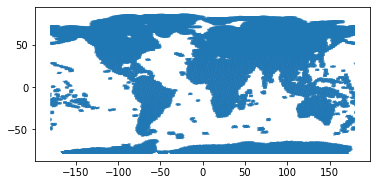

In [16]:
df_triplet_over_land.plot()

# Connected Components

The land intersection breaks apart each "relative orbit" (or "track") and so we are going to break it apart by transforming the sequential burst ids.

In [17]:
def replace_groups(data):
    """Source: https://stackoverflow.com/a/15709547
    
    Takes a list/array of integers and outputs unique sequential numbers
    """
    a,b,c, = np.unique(data, True, True)
    _, ret = np.unique(b[c], False, True)
    return ret

In [18]:
# The burst ids should be sequential unless the track misses bursts. The initial transformation thus should be
# 0 along connected components and take jumps elsewhere
temp = (df_triplet_over_land.burst_id.diff() - 1).cumsum()
# The first element of diff is np.nan
temp[:1] = 0
# Ensure uniqueness
temp = replace_groups(temp.astype(int))
df_triplet_over_land['cc_index'] = temp.astype(int)
df_triplet_over_land.head()

,burst_id,geometry,OGC_FID_min,OGC_FID_max,relative_orbit_numbers,look_direction,cc_index
14,15,"POLYGON Z ((3.64198 3.24511 0.00000, 3.27492 3...",43,45,1,ASCENDING,0
15,16,"POLYGON Z ((3.60746 3.41182 0.00000, 3.24034 3...",46,48,1,ASCENDING,0
16,17,"POLYGON Z ((3.57295 3.57853 0.00000, 3.20578 3...",49,51,1,ASCENDING,0
17,18,"POLYGON Z ((3.53706 3.74496 0.00000, 3.16973 3...",52,54,1,ASCENDING,0
18,19,"POLYGON Z ((3.50260 3.91168 0.00000, 3.13521 3...",55,57,1,ASCENDING,0


Can save a small chunk to be viewed in QGIS.

In [19]:
# df_triplet_over_land.iloc[:1_000].to_file('cc_index_test')

# Collect Frames by Burst Triplet

We need overlapping frames. We set the burst id to be the index of the dataframe within each connected component and traverse that way. This was fasted from what I tested and it was not clear how to use groupby for overlapping rows.

I do alot of aggregation for accounting. This makes the dissolve much slower. This can be sped up removing the `agg_dict`.

In [20]:
def join_track_numbers_2(orbit_str_l: list) -> str:
    orbit_str_all = [orbit for orbit_str in orbit_str_l for orbit in orbit_str.split(',')]
    orbit_unique = list(set(orbit_str_all))
    return ','.join(orbit_unique)

def join_look_direction(look_direction_l: list) -> str:
    return ','.join(list(set(look_direction_l)))

def extract_frames(df_group, 
                   n_bursts_per_swath = 10, 
                   o_bursts_per_swath = 2):
    
    if df_group.empty:
        return df_group
    
    # Index Accounting
    O = o_bursts_per_swath
    N = n_bursts_per_swath

    min_triplet_id = df_group.burst_id.min()
    max_triplet_id = df_group.burst_id.max()
    total_triplets_float = (max_triplet_id - min_triplet_id) / (N - O)
    total_triplets = int(np.ceil(total_triplets_float))
    triplets_remainder = (max_triplet_id - min_triplet_id) % (N - O)
    
    T = max(total_triplets, 1)

    df_temp = df_group.copy()
    df_temp = df_temp.set_index('burst_id')

    # Note the index
    starts = [max(k * (N - O), 0) for k in range(T)]
    stops = [s + N for s in starts]
    
    agg_dict = {'OGC_FID_min': 'min',
                'OGC_FID_max': 'max',
                'burst_id': ['min', 'max'],
                'relative_orbit_numbers': join_track_numbers_2,
                'look_direction': join_look_direction, 
                'cc_index': 'first'}
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        frames_l = [df_temp.iloc[start: stop].reset_index(drop=False).dissolve(aggfunc=agg_dict) 
                    for start, stop in zip((starts), stops)]

    if (T > 1) and (triplets_remainder < (N - O)):
        last_dfs = frames_l[-2:]
        frames_l = frames_l[:-2]

        df_last = pd.concat(last_dfs, axis=0).dissolve()

        frames_l.append(df_last)
        
    df_frames = pd.concat(frames_l, axis=0)
    
    df_frames.columns = ['geometry', 
                         'OGC_FID_min', 
                         'OGC_FID_max', 
                         'burst_id_min',
                         'burst_id_max',
                         'relative_orbit_numbers', 
                         'look_direction',
                         'connected_component']
    
    return df_frames

In [21]:
%%time

df_frames_l = [extract_frames(df_group) for _, df_group in tqdm(df_triplet_over_land.groupby('cc_index'))]
df_frames_l[0]

100%|████████████| 1906/1906 [03:55<00:00,  8.08it/s]

CPU times: user 3min 54s, sys: 1.73 s, total: 3min 56s
Wall time: 3min 55s


,geometry,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,connected_component
0,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3...",43,72,15,24,1,ASCENDING,0
0,"POLYGON Z ((2.56639 4.59014 0.00000, 2.56639 4...",67,96,23,32,1,ASCENDING,0
0,"POLYGON Z ((2.28948 5.92481 0.00000, 2.28948 5...",91,120,31,40,1,ASCENDING,0
0,"POLYGON Z ((2.01349 7.25953 0.00000, 2.01349 7...",115,144,39,48,1,ASCENDING,0
0,"POLYGON Z ((1.73823 8.59428 0.00000, 1.73823 8...",139,168,47,56,1,ASCENDING,0
0,"POLYGON Z ((1.45775 9.95702 0.00000, 1.45775 9...",163,192,55,64,1,ASCENDING,0
0,"POLYGON Z ((1.18914 11.26370 0.00000, 1.18914 ...",187,216,63,72,1,ASCENDING,0
0,"POLYGON Z ((0.91212 12.61163 0.00000, 0.87479 ...",211,240,71,80,1,ASCENDING,0
0,"POLYGON Z ((0.63804 13.94393 0.00000, 0.60392 ...",235,264,79,88,1,ASCENDING,0
0,"POLYGON Z ((0.36263 15.28115 0.00000, 0.32721 ...",259,288,87,96,1,ASCENDING,0


Because we concat, each index is `0`. We re-index and then we reindex again so we can assign each row a `frame_id`.

In [22]:
df_frames_final = pd.concat(df_frames_l, axis=0).reset_index(drop=True).reset_index(drop=False)
df_frames_final = df_frames_final.rename(columns={'index': 'frame_id'})
df_frames_final.head()

,frame_id,geometry,OGC_FID_min,OGC_FID_max,burst_id_min,burst_id_max,relative_orbit_numbers,look_direction,connected_component
0,0,"POLYGON Z ((2.84448 3.25558 0.00000, 2.84448 3...",43,72,15,24,1,ASCENDING,0
1,1,"POLYGON Z ((2.56639 4.59014 0.00000, 2.56639 4...",67,96,23,32,1,ASCENDING,0
2,2,"POLYGON Z ((2.28948 5.92481 0.00000, 2.28948 5...",91,120,31,40,1,ASCENDING,0
3,3,"POLYGON Z ((2.01349 7.25953 0.00000, 2.01349 7...",115,144,39,48,1,ASCENDING,0
4,4,"POLYGON Z ((1.73823 8.59428 0.00000, 1.73823 8...",139,168,47,56,1,ASCENDING,0


In [23]:
df_frames_final.to_file('s1_frames.geojson', driver='GeoJSON')